# Notebook with examples on how to use the lineages from Guignard et al.

## Import of the necessary libraries

In [1]:
import os
from useful_functions import (get_symetric_volumes, plot_around_div,
                              get_life_span, read_property_file,
                              compute_neighbors_stability,
                              get_ratio_mother_sisters_volume)
from colormap import ColorMap
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
%matplotlib inline

## Loading the data

The datasets can be retrieved [there](https://figshare.com/s/765d4361d1b073beedd5). The lineage and geometrical data are stored in the tar archives named `*_properties.tar.gz`. Within these archives there are a pickle (`.pkl`) and an xml (`.xml`) file which contain the information necessary for this notebook to work.

Once these data downloaded, the function `read_property_file` allows to load such an xml or pickle file and returns a dictionary that maps a property name to the dictionary containing this propery:
```python
properties = {property_name(string): property_dict(dict), ... }
```
- `"cell_lineage"` is the lineage tree as a dictionary that maps a cell id at time $t$ to the `list` of its correspondant cell id(s) at time $t+1$.
```python
{mother_cell_id(int): [daughter_cell_id_1(int), ...], ...}
```
- `"all_cells"` is the list of all the cell ids:
```python
[cell_id(int), ...]
```
- `"cell_history"` is a dictionary that maps a cell id to the list of all the cell ids that represent the same cell (ids in time):
```python
{cell_id(int): [cell_id2(int), cell_id2(int), ...], ...}
```
- `"cell_label_in_time"` maps a time $t$ to the list of cells that exist at that time:
```python
{time(int): [cell_id1(int), cell_id2(int), ...], ...}
```
- The other dictionaries map a cell id to its associated values:
 - `"cell_name"` maps the names of the cells as defined by Conklin (after manual correction).
 - `"cell_barycenter"` maps the cell barycenters
 
 - `"cell_fate"`, `"cell_fate_2"` and `"cell_fate_3"` represent different fate mappings (`"cell_fate_3"` is the one used for this paper).
 - `"cell_volume"` maps the volume of the cells in voxels (computed as the sum of voxels inside the segmented cell).
 - `"cell_contact_surface"` maps the cell-cell surface of contacts in voxels (as described in Supp 5.2). `"cell_contact_surface"` is a dictionary of dictionaries:
```python
{cell_id(int): {cell_neighbour_id(int): area_of_contact(float), ...}, ... }
```
In this dictionary if `cell_neighbour_id//10**4==1` then this `cell_neighbour_id` represents the surface of contact to the outside.


It is worth noticing that the cell id are implemented in a way that it is possible to extract the time it belongs too and the corresponding label in the image data:
- `cell_id = t*10**4 + label`

hence:
- `label = cell_id%10**4` is the corresonding label in the image
- `t = cell_id//10**4` is the corresponding time (note that // is the floor division)

__SINCE THE AMOUNT OF DATA IS LARGE, THE LOADING TIME MIGHT TAKE SEVERAL MINUTES__

### Paths definition

In [2]:
# Path to the data.
# You need to download the data from the figshare link
# specified above and put the xml/pkl file in the folder specified in the following line (Data by default)
path_to_data = './Data/'

# This is the path where the figures will be saved
path_to_figures = './Outputs_figures/'

### Build a color map from the different tissues in our datasets

In [3]:
## Building the color map
tissue_order = ['Head Endoderm', '1st Endodermal Lineage',
                '2nd Endodermal Lineage', 'Head Epidermis',
                'Tail Epidermis', 'Germ Line',
                'Mesenchyme', '1st Lineage, Tail Muscle',
                '2nd Lineage, Tail Muscle', '1st Lineage, Notochord',
                '2nd Lineage, Notochord',
                'Trunk Lateral Cell',
                'Trunk Ventral Cell',
                'Anterior Dorsal Neural Plate',
                'Anterior Ventral Neural Plate',
                'Posterior Dorsal Neural Plate',
                'Posterior Lateral Neural Plate',
                'Posterior Ventral Neural Plate']
CMapFates = ColorMap(tissue_order+['undeter'], 'rainbow')

### Loading and preping the data

In [4]:
# Load the data, the output is the property file specified above
properties = read_property_file(os.path.join(path_to_data + 'Astec-Pm1_properties.pkl'))

lin_tree = properties['cell_lineage']
names = properties['cell_name']
fates = properties['cell_fate']
fates2 = properties['cell_fate_2']
fates3 = properties['cell_fate_3']
vol = properties['cell_volume']
surf_ex = properties['cell_contact_surface']
prob_cells = properties['problematic_cells']

# Removing the potential problematic cells
for c in prob_cells:
    lin_tree.pop(c, None)

# Building the inverse lineage tree (daughter cell -> mother cell)
inv_lin_tree = {daught: mother for mother, daughters in list(lin_tree.items()) for daught in daughters}

# Building the cell surfaces
surfaces = {cell:np.sum(list(neighbors.values())) for cell, neighbors in list(surf_ex.items())}

# Building the compactness metric
comp = {cell:vol[cell]**(1/3.)/surfaces[cell]**(1/2.) for cell in vol}

# Morphological attributes of the cells

## Distribution of the evolution of volume before and after the division

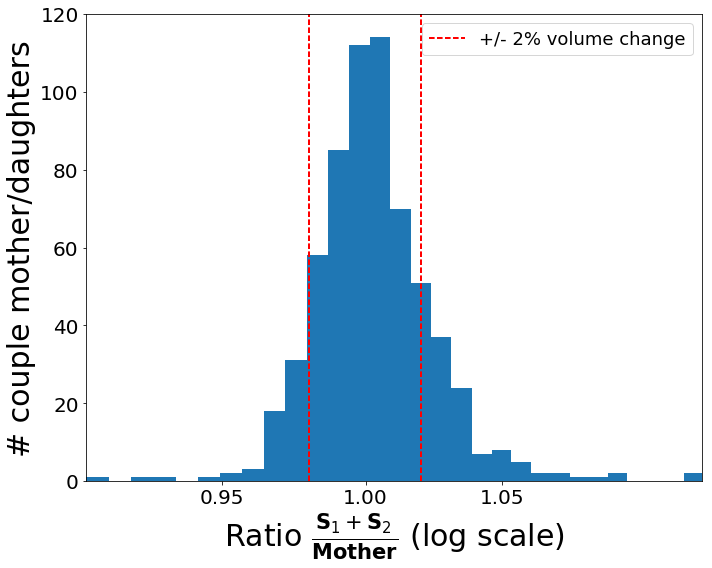

In [5]:
ratio_daugthers = [get_ratio_mother_sisters_volume(c, vol, lin_tree, inv_lin_tree, 5) 
                   for c, v in list(lin_tree.items()) if len(v) == 2]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.hist(ratio_daugthers, bins=30)
ax.set_xscale('log')
ax.set_xlim(np.min(ratio_daugthers), np.max(ratio_daugthers))
ax.plot([0.98, 0.98], [0, 150], 'r--', lw=2, label='+/- 2% volume change')
ax.plot([1.02, 1.02], [0, 150], 'r--', lw=2)
ax.set_ylim(0, 120)
ax.legend(fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xticks([.95, 1, 1.05])
ax.set_xlabel(r'Ratio $\frac{\mathbf{S}_1 + \mathbf{S}_2}{\mathbf{Mother}}$ (log scale)', fontsize=30)
ax.set_ylabel('# couple mother/daughters', fontsize=30)
fig.tight_layout()

## Left/Right comparison of cell volumes

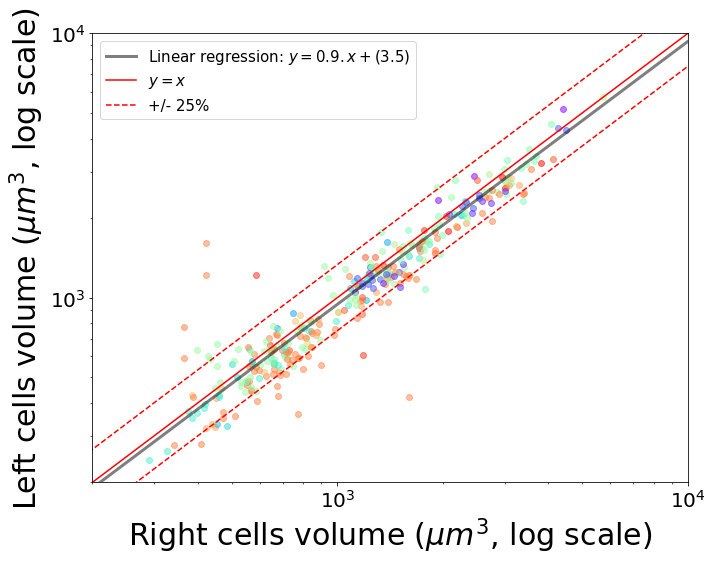

In [6]:
mother_cells = [c for c, v in list(inv_lin_tree.items()) if len(lin_tree[v]) == 2 and c in names]
couples = []
for c in mother_cells:
    if names[c][-1]=='*':
        for ci in mother_cells:
            if names[c][:-1]==names[ci][:-1] and c!=ci:
                couples.append((c, ci))

X = []
Y = []
C = []
for cs in couples:
    x, y = get_symetric_volumes(cs, vol, lin_tree)
    X.append(x*.3**3)
    Y.append(y*.3**3)
    C.append(cs[0])
                

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.set_yscale('log')
ax.set_xscale('log')
for c, x, y in zip(C, X, Y):
    ax.plot(x, y, 'o', color = CMapFates(fates3.get(c, 'undeter')), alpha=.5)

slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)
ax.plot([100, 10**5], [slope*100+intercept, slope*10**5+intercept], 'k-', lw=3, alpha=.5,
        label=r'Linear regression: $y=%10.1f.x+(%10.1f)$'%(slope,+intercept))

ax.plot([100, 10**5], [100, 10**5], 'r-', label=r'$y=x$')
ax.plot([100, 10**5], [0.75*100, 0.75*10**5], 'r--', label='+/- 25%')
ax.plot([100, 10**5], [(1/0.75)*100, (1/0.75)*10**5], 'r--')
ax.set_xlim(200, 10000)
ax.set_ylim(200, 10000)
ax.legend(loc='upper left', fontsize=15)
ax.set_xlabel(r'Right cells volume ($\mu m^3$, log scale)', fontsize=30)
ax.set_ylabel(r'Left cells volume ($\mu m^3$, log scale)', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)
fig.tight_layout()

## Cell compactness around division events

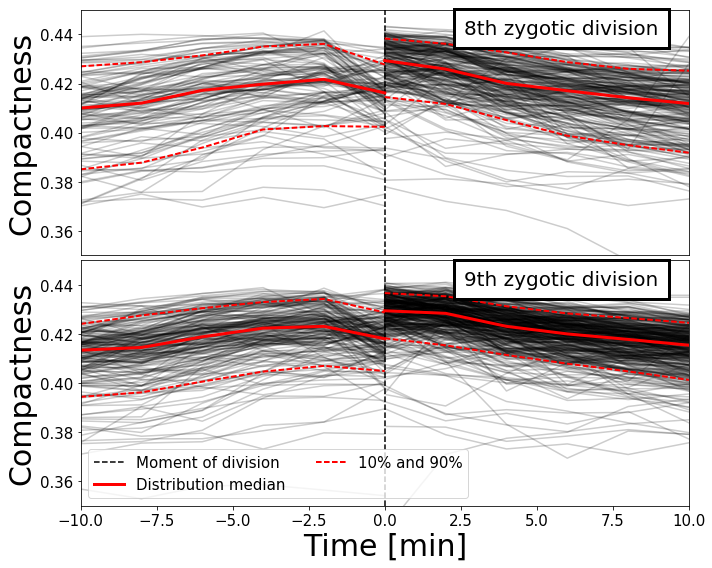

In [7]:
interest_cells = [c for c, v in list(lin_tree.items()) if (len(v) == 2
                                                         and ('8.' in names.get(c, '') or
                                                              '9.' in names.get(c, '')))]
plot_around_div(comp, lin_tree, inv_lin_tree, interest_cells, names, col=1, row=2, ylim=(0.35, 0.45),
                x_label='Time [min]', y_label='Compactness', around=5)

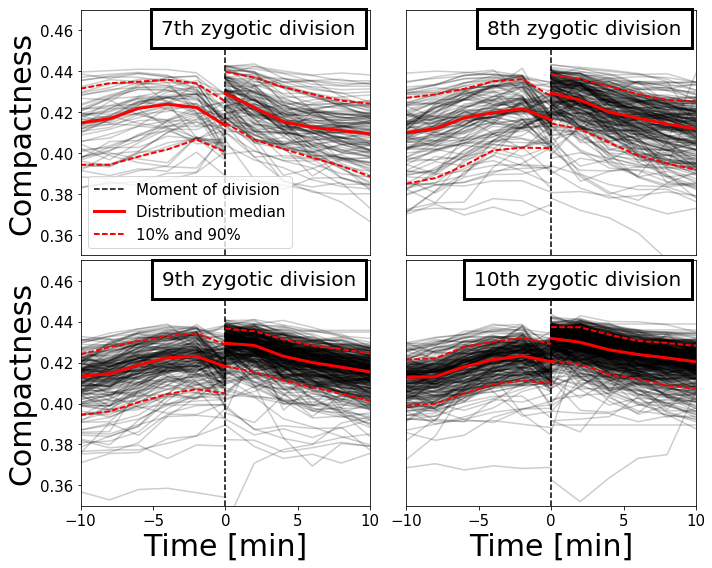

In [8]:
interest_cells = [c for c, v in list(lin_tree.items()) if len(v) == 2 and ('7.' in names.get(c, '') or
                                                                         '8.' in names.get(c, '') or
                                                                         '9.' in names.get(c, '') or
                                                                         '10.' in names.get(c, ''))]
plot_around_div(comp, lin_tree, inv_lin_tree, interest_cells, names, col=2, row=2, ylim=(0.35, 0.47),
                x_label='Time [min]', y_label='Compactness', around=5,
                z_c_range = (7, 11), add_title='_supp', legend_pos=1, ncol=1)

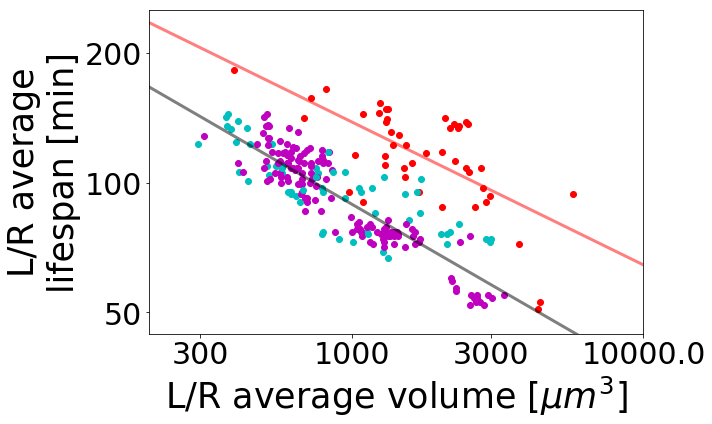

In [9]:

COMBINE_Epi_Neur = True ## True to combine epithelial layers, False to split them in Neural and Epidermal

mother_cells = [c for c, v in list(inv_lin_tree.items()) if len(lin_tree[v]) == 2 and c in names]
couples = []
for c in mother_cells:
    if names[c][-1]=='*':
        for ci in mother_cells:
            if names[c][:-1]==names[ci][:-1] and c!=ci:
                couples.append((c, ci))

volumes = []
life_span = []
C = []
for cs in couples:
    ctmp = cs[0]
    while len(lin_tree.get(ctmp, [])) == 1:
        ctmp = lin_tree[ctmp][0]
    t_tmp = ctmp//10**4
    ctmp = cs[1]
    while len(lin_tree.get(ctmp, [])) == 1:
        ctmp = lin_tree[ctmp][0]
    t_tmp = max(ctmp//10**4, t_tmp)
    if t_tmp < 180:
        x, y = get_symetric_volumes(cs, vol, lin_tree)
        volumes.append((np.mean([x, y])*.3**3))
        life_span += [np.mean(get_life_span(cs, lin_tree))*2]
        C.append(cs[0])

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
X1, Y1, X2, Y2, X3, Y3 = [], [], [], [], [], []
for c, x, y in zip(C, volumes, life_span):
    if "Neural" in fates2.get(c, 'undeter'):
        X1 += [np.log10(x)]
        Y1 += [np.log10(y)]
        ax.plot(np.log10(x), np.log10(y), 'co', )
    elif "Epider" in fates2.get(c, 'undeter'):
        X2 += [np.log10(x)]
        Y2 += [np.log10(y)]
        ax.plot(np.log10(x), np.log10(y), 'mo')
    elif "Mesoderm" in fates2.get(c, 'undeter'):
        X3 += [np.log10(x)]
        Y3 += [np.log10(y)]
        ax.plot(np.log10(x), np.log10(y), 'ro')

ax.plot(-1, -1, 'ro', label = 'Mesodermal cells')
ax.plot(-1, -1, 'mo', label = 'Epidermal cells')
ax.plot(-1, -1, 'co', label = 'Neural cells')

if COMBINE_Epi_Neur:
    slope, intercept, r_value, p_value, std_err = stats.linregress(X1+X2, Y1+Y2)
    ax.plot([2, 5], [slope*(2)+intercept, slope*5+intercept], 'k-', lw=3, alpha = .5)
    a1, b1 = slope, 10**intercept
else:
    slope, intercept, r_value, p_value, std_err = stats.linregress(X1, Y1)
    ax.plot([2, 5], [slope*(2)+intercept, slope*5+intercept], 'c-', lw=3, alpha = .5)
    a1, b1 = slope, 10**intercept

    slope, intercept, r_value, p_value, std_err = stats.linregress(X2, Y2)
    ax.plot([2, 5], [slope*(2)+intercept, slope*5+intercept], 'm-', lw=3, alpha = .5)
    a2, b2 = slope, 10**intercept


slope, intercept, r_value, p_value, std_err = stats.linregress(X3, Y3)
ax.plot([2, 5], [slope*(2)+intercept, slope*5+intercept], 'r-', lw=3, alpha = .5)
a3, b3 = slope, 10**intercept

ax.set_ylim((1.65, 2.4))
ax.set_xlim((np.log10(200), np.log10(10000)))
ax.set_xticks(np.log10([300, 1000, 3000, 1e4]))
ax.set_xticklabels([300, 1000, 3000, 1e4])
ax.set_yticks(np.log10([50, 100, 200]))
ax.set_yticklabels([50, 100, 200])
ax.set_xlabel(r'L/R average volume [$\mu m^3$]', fontsize=35)
ax.set_ylabel('L/R average\nlifespan [min]', fontsize=35)
ax.tick_params(axis='both', which='major', labelsize=30)
fig.tight_layout()

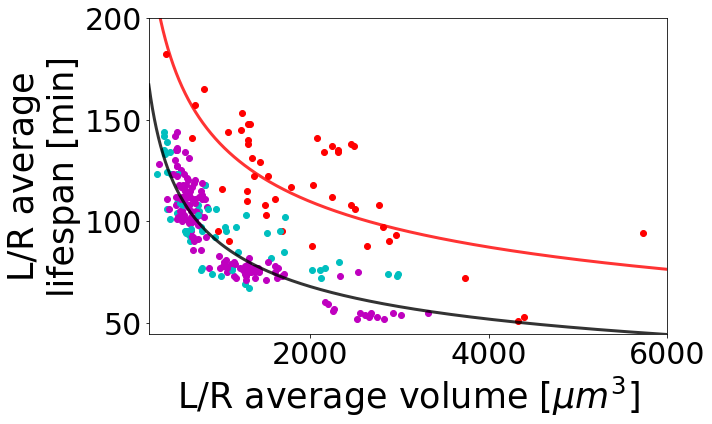

In [10]:
mother_cells = [c for c, v in list(inv_lin_tree.items()) if len(lin_tree[v]) == 2 and c in names]
couples = []
for c in mother_cells:
    if names[c][-1]=='*':
        for ci in mother_cells:
            if names[c][:-1]==names[ci][:-1] and c!=ci:
                couples.append((c, ci))

volumes = []
life_span = []
C = []
for cs in couples:
    ctmp = cs[0]
    while len(lin_tree.get(ctmp, [])) == 1:
        ctmp = lin_tree[ctmp][0]
    t_tmp = ctmp//10**4
    ctmp = cs[1]
    while len(lin_tree.get(ctmp, [])) == 1:
        ctmp = lin_tree[ctmp][0]
    t_tmp = max(ctmp//10**4, t_tmp)
    if t_tmp < 180:
        x, y = get_symetric_volumes(cs, vol, lin_tree)
        volumes.append((np.mean([x, y])*.3**3))
        life_span += [np.mean(get_life_span(cs, lin_tree))*2]
        C.append(cs[0])

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
X1, Y1, X2, Y2 = [], [], [], []
for c, x, y in zip(C, volumes, life_span):
    if "Neural" in fates2.get(c, 'undeter'):
        X1 += [(x)]
        Y1 += [(y)]
        ax.plot((x), (y), 'co', )
    elif "Epider" in fates2.get(c, 'undeter'):
        X1 += [(x)]
        Y1 += [(y)]
        ax.plot((x), (y), 'mo')
    elif "Mesoderm" in fates2.get(c, 'undeter'):
        X2 += [(x)]
        Y2 += [(y)]
        ax.plot((x), (y), 'ro')

min_X = min(X1 + X2 + X3)
if COMBINE_Epi_Neur:
    X = np.arange(min_X, 30000, 2)
    Y = b1*X**a1
    ax.plot(X, Y, 'k-', lw = 3, alpha = .8)
else:
    X = np.arange(min_X, 30000, 2)
    Y = b1*X**a1
    ax.plot(X, Y, 'c-', lw = 3, alpha = .8)

    X = np.arange(min_X, 30000, 2)
    Y = b2*X**a2
    ax.plot(X, Y, 'm-', lw = 3, alpha = .8)

X = np.arange(min_X, 30000, 2)
Y = b3*X**a3
ax.plot(X, Y, 'r-', lw = 3, alpha = .8)
ax.set_ylim((10**1.65, 200))
ax.set_xlim((200, 6000))
ax.set_xlabel(r'L/R average volume [$\mu m^3$]', fontsize=35)
ax.set_ylabel('L/R average\nlifespan [min]', fontsize=35)
ax.tick_params(axis='both', which='major', labelsize=30)
fig.tight_layout()

In [11]:
cells_epidermis = [c for c in list(lin_tree.keys()) if (len(lin_tree.get(inv_lin_tree.get(c, -1), [])) == 2 and
                                            "Epider" in fates3.get(c, ''))]
cells_mesendo = [c for c in list(lin_tree.keys()) if (len(lin_tree.get(inv_lin_tree.get(c, -1), [])) == 2 and
                                                    c in fates3 and not "Epider" in fates3[c] and
                                                    not "Germ" in fates3[c] and
                                                    not "Neural" in fates3[c])]

cells_NP = [c for c in list(lin_tree.keys()) if (len(lin_tree.get(inv_lin_tree.get(c, -1), [])) == 2 and
                                               "Neural" in fates3.get(c, ''))]


cell_cycles_epidermis = []
for c in cells_epidermis:
    c_cycle = [c]
    while len(lin_tree.get(c_cycle[-1], [])) == 1:
        c_cycle += lin_tree[c_cycle[-1]]
    if c_cycle[-1]/10**4 < 180:
        cell_cycles_epidermis.append(c_cycle)
        
cell_cycles_mesendo = []
for c in cells_mesendo:
    c_cycle = [c]
    while len(lin_tree.get(c_cycle[-1], [])) == 1:
        c_cycle += lin_tree[c_cycle[-1]]
    if c_cycle[-1]/10**4 < 180:
        cell_cycles_mesendo.append(c_cycle)
        
cell_cycles_NP = []
for c in cells_NP:
    c_cycle = [c]
    while len(lin_tree.get(c_cycle[-1], [])) == 1:
        c_cycle += lin_tree[c_cycle[-1]]
    if c_cycle[-1]/10**4 < 180:
        cell_cycles_NP.append(c_cycle)
        

        
v1_epidermis = []
v2_epidermis = []
v1_mesendo = []
v2_mesendo = []
v1_NP = []
v2_NP = []
for c in cell_cycles_epidermis:
    v1, v2 = compute_neighbors_stability(c, lin_tree, surf_ex, fates3, surfaces, inv_lin_tree,
                                         th_presence = .1, th = .03, smoothing_percentage = .2)
    v1_epidermis.append(v1)
    v2_epidermis.append(v2)

for c in cell_cycles_mesendo:
    v1, v2 = compute_neighbors_stability(c, lin_tree, surf_ex, fates3, surfaces, inv_lin_tree,
                                         th_presence = .1, th = .03, smoothing_percentage = .2)
    v1_mesendo.append(v1)
    v2_mesendo.append(v2)

    
for c in cell_cycles_NP:
    v1, v2 = compute_neighbors_stability(c, lin_tree, surf_ex, fates3, surfaces, inv_lin_tree,
                                         th_presence = .1, th = .03, smoothing_percentage = .2)
    v1_NP.append(v1)
    v2_NP.append(v2)


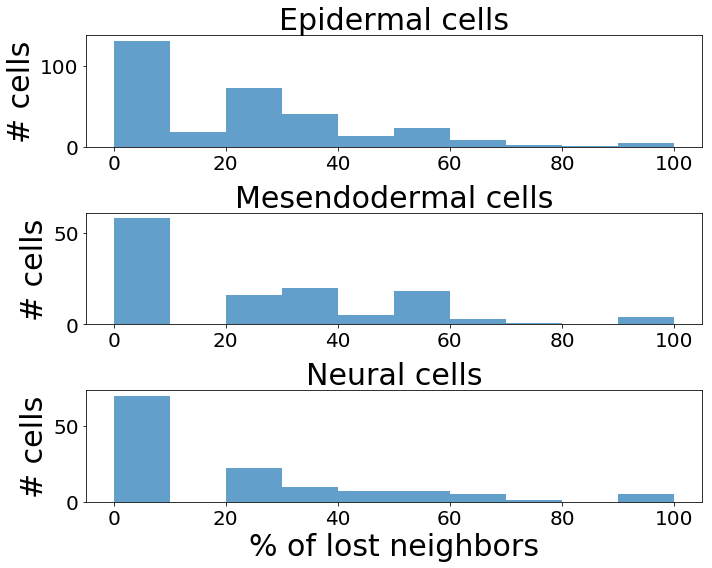

In [12]:
fig = plt.figure(figsize = (10, 8))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

nb_bins = max(v1_epidermis+v1_mesendo+v1_NP)+1

ax1.hist(100*np.array(v2_epidermis), bins = 10, range=(0, 100), alpha = .7)
ax2.hist(100*np.array(v2_mesendo), bins = 10, range=(0, 100), alpha = .7)
ax3.hist(100*np.array(v2_NP), bins = 10, range=(0, 100), alpha = .7)

ax1.set_title('Epidermal cells', fontsize=30)
ax1.set_ylabel('# cells', fontsize=30)
ax1.tick_params(axis='both', which='major', labelsize=20)

ax2.set_title('Mesendodermal cells', fontsize=30)
ax2.set_ylabel('# cells', fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=20)

ax3.set_title('Neural cells', fontsize=30)
ax3.set_xlabel('% of lost neighbors', fontsize=30)
ax3.tick_params(axis='both', which='major', labelsize=20)
ax3.set_ylabel('# cells', fontsize=30)
fig.tight_layout()